<a href="https://colab.research.google.com/github/hazelkozlu/CoreDemo/blob/master/makaleresnet50son3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#google drive bağlantısı için
from  google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Colab Notebooks/

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


In [2]:

import numpy as np
import pandas as pd
import os, random, math, glob, cv2, pickle
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import  train_test_split
from keras.utils import to_categorical
##from sklearn.decomposition import PCA
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

In [3]:

import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionResNetV2, VGG16, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD


In [4]:
import fnmatch
import numpy as np
from sklearn.utils import class_weight
y = []
class_names = ["yaprakdelen", "saglikli", "potasyumeksik", "kulleme"]

for class_name in class_names:
    y.extend([class_names.index(class_name) for _ in range(len(fnmatch.filter(os.listdir('TezVeriSeti/train/' + class_name), '*.png')))])

print(np.bincount(y))

from sklearn.utils.class_weight import compute_sample_weight
import numpy as np

# Sınıf ağırlıkları
class_weights = compute_sample_weight(class_weight='balanced', y=y)

# Sınıf ağırlıklarını sınıflara göre düzenle
class_weights_dict = dict(zip(range(4), np.unique(y, return_counts=True)[1] / np.bincount(y)))
print(class_weights_dict)




[240 240 240 238]
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [5]:

model_to_use='resnet50'

base_model=ResNet50(weights='imagenet',include_top=False)
for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dense(128,activation='relu')(x)
preds=Dense(4,activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=preds)

94765736/94765736 [==============================] - 1s 0us/step


In [6]:
train_save= 'TezVeriSeti/train'
val_save = 'TezVeriSeti/valid'

#train
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    rotation_range=15,
                                    shear_range=0.2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    brightness_range=(0.1, 0.9),
                                    channel_shift_range=150.0,
                                    horizontal_flip=True)

train_generator=train_datagen.flow_from_directory(train_save,
                                                target_size=(224,224),
                                                color_mode='rgb',
                                                batch_size=16,
                                                class_mode='categorical',
                                                shuffle=True)
# val
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator=val_datagen.flow_from_directory(val_save,
                                                target_size=(224,224),
                                                color_mode='rgb',
                                                batch_size=16,
                                                class_mode='categorical',
                                                shuffle=False)

Found 958 images belonging to 4 classes.
Found 960 images belonging to 4 classes.


In [7]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size

earlystop = EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint = ModelCheckpoint('model-epoch-{epoch:03d}-valacc-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')

no_epochs = 25
hist = model.fit(train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=no_epochs,
                   validation_data=val_generator,
                   validation_steps=step_size_val,
                   callbacks=[earlystop, checkpoint], #callbacks=[checkpoint],
                   class_weight=class_weights_dict)


Epoch 1/25
59/59 [==============================] - ETA: 0s - loss: 0.8337 - accuracy: 0.6433
Epoch 1: val_accuracy improved from -inf to 0.75729, saving model to model-epoch-001-valacc-0.757292.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 497s 8s/step - loss: 0.8337 - accuracy: 0.6433 - val_loss: 0.5338 - val_accuracy: 0.7573
Epoch 2/25
59/59 [==============================] - ETA: 0s - loss: 0.5854 - accuracy: 0.7463
Epoch 2: val_accuracy improved from 0.75729 to 0.80417, saving model to model-epoch-002-valacc-0.804167.h5
59/59 [==============================] - 383s 7s/step - loss: 0.5854 - accuracy: 0.7463 - val_loss: 0.4480 - val_accuracy: 0.8042
Epoch 3/25
59/59 [==============================] - ETA: 0s - loss: 0.5163 - accuracy: 0.7898
Epoch 3: val_accuracy did not improve from 0.80417
59/59 [==============================] - 373s 6s/step - loss: 0.5163 - accuracy: 0.7898 - val_loss: 0.5505 - val_accuracy: 0.7594
Epoch 4/25
59/59 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.7966
Epoch 4: val_accuracy improved from 0.80417 to 0.84375, saving model to model-epoch-004-valacc-0.843750.h5
59/59 [==============================] - 333s 6s/step - loss: 0

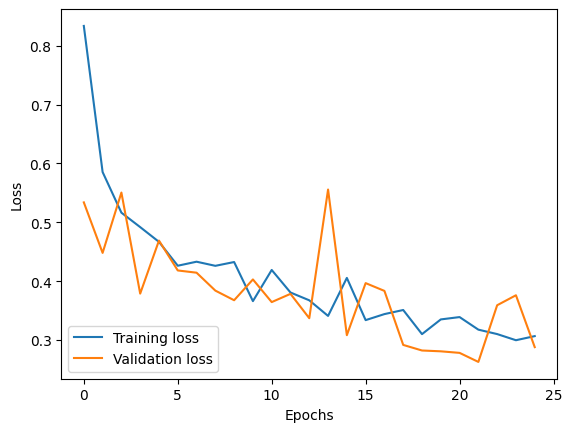

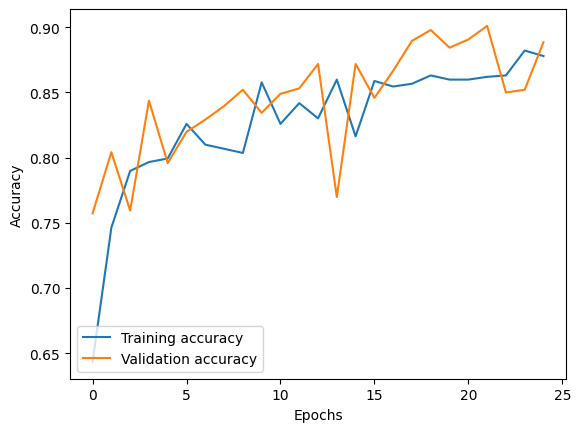

60/60 [==============================] - 167s 3s/step
Confusion Matrix:
[[240   0   0   0]
 [  1 217   3  19]
 [  1   1 208  30]
 [  0  34  18 188]]

Classification Report:
                precision    recall  f1-score   support

      kulleme       0.99      1.00      1.00       240
potasyumeksik       0.86      0.90      0.88       240
     saglikli       0.91      0.87      0.89       240
  yaprakdelen       0.79      0.78      0.79       240

     accuracy                           0.89       960
    macro avg       0.89      0.89      0.89       960
 weighted avg       0.89      0.89      0.89       960



In [8]:

# visualizing losses and accuracy
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_accu = hist.history['accuracy']
val_accu = hist.history['val_accuracy']
xc = range(len(train_loss))

plt.figure()
plt.plot(xc, train_loss, label='Training loss')
plt.plot(xc, val_loss, label='Validation loss')
plt.legend(loc="lower left")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('train_val_loss.png')
plt.show()

plt.figure()
plt.plot(xc, train_accu, label='Training accuracy')
plt.plot(xc, val_accu, label='Validation accuracy')
plt.legend(loc="lower left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('train_val_accuracy.png')
plt.show()
from sklearn.metrics import confusion_matrix, classification_report

# Modelin doğrulama verileri üzerinde tahminlerini alın
y_pred = model.predict(val_generator, steps=step_size_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek etiketleri alın
y_true = val_generator.classes

# Karmaşıklık matrisini hesaplayın
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Karmaşıklık matrisini yazdırın
print("Confusion Matrix:")
print(confusion_mtx)

# Sınıflandırma raporunu hesaplayın ve yazdırın
class_report = classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices)
print("\nClassification Report:\n", class_report)


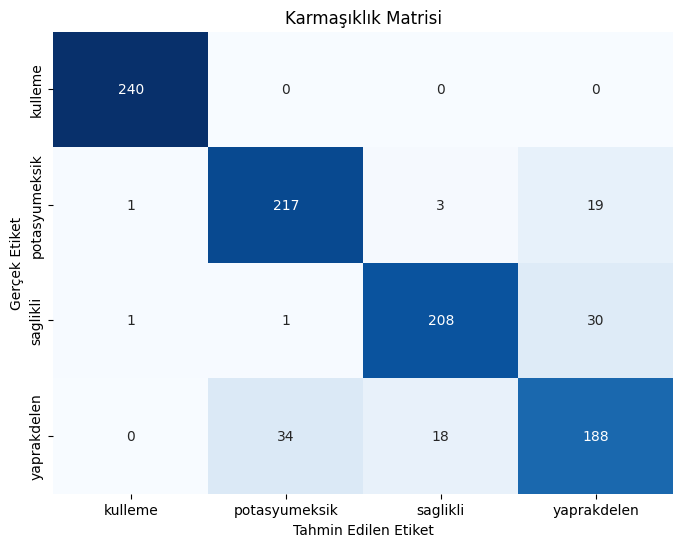

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Karmaşıklık matrisini ısı haritası olarak çizin
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Karmaşıklık Matrisi')
plt.show()


In [10]:
final_accuracy = hist.history['accuracy'][-1]
print("Final Training Accuracy:", final_accuracy)


Final Training Accuracy: 0.8779193162918091
